In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna import Trial
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(
    "../input/10min/vcenter.csv", usecols=["date", "value"], parse_dates=["date"]
)
print(df.shape)
df.head()

(52151, 2)


,date,value
0,2020-02-19 09:00:00,10
1,2020-02-19 09:10:00,11
2,2020-02-19 09:20:00,11
3,2020-02-19 09:30:00,11
4,2020-02-19 09:40:00,11


In [3]:
df.rename(columns={"date": "ds", "value": "y"}, inplace=True)
df["ds"] = pd.to_datetime(df["ds"])
df.tail()

,ds,y
52146,2021-02-17 08:10:00,29
52147,2021-02-17 08:20:00,28
52148,2021-02-17 08:30:00,28
52149,2021-02-17 08:40:00,29
52150,2021-02-17 08:50:00,29


In [4]:
train = df[df['ds'] < '2021-01-01']
valid = df.copy()
valid["days"] = valid["ds"].apply(lambda x: x.day)
valid = valid.groupby("days")["y"].agg("mean")

In [5]:
def objective(trial: Trial) -> float:
    params = {
        "epochs": trial.suggest_categorical("epochs", [50, 100, 200, 300, 400, 500]),
        "batch_size": 64,
        "num_hidden_layers": trial.suggest_int("num_hidden_layers", 0, 5),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1),
        "changepoints_range": trial.suggest_discrete_uniform(
            "changepoints_range", 0.8, 0.95, 0.001
        ),
        "n_changepoints": trial.suggest_int("n_changepoints", 20, 35),
        "seasonality_mode": "additive",
        "yearly_seasonality": False,
        "weekly_seasonality": True,
        "daily_seasonality": True,
        "loss_func": "MSE",
    }
    # fit_model
    m = NeuralProphet(**params)
    m.fit(train, freq="1D")
    future = m.make_future_dataframe(train, periods=len(valid), n_historic_predictions=True)

    forecast = m.predict(future)
    valid_forecast = forecast[forecast.y.isna()]
    val_rmse = mean_squared_error(valid_forecast.yhat1, valid, squared=False)

    return val_rmse

In [6]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=20)

[I 2021-05-12 14:33:42,344] A new study created in memory with name: no-name-4844456d-f987-4186-b498-38e6b45fdc0a
Epoch[100/100]: 100%|██████████| 100/100 [01:36<00:00,  1.04it/s, MSELoss=0.0165, MAE=1.08, RegLoss=0]
[I 2021-05-12 14:35:19,527] Trial 0 finished with value: 7.225570161945696 and parameters: {'epochs': 100, 'num_hidden_layers': 0, 'learning_rate': 0.08675143843171859, 'changepoints_range': 0.89, 'n_changepoints': 31}. Best is trial 0 with value: 7.225570161945696.
Epoch[100/100]: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s, MSELoss=0.0152, MAE=1.01, RegLoss=0]
[I 2021-05-12 14:36:53,855] Trial 1 finished with value: 6.825792779153894 and parameters: {'epochs': 100, 'num_hidden_layers': 1, 'learning_rate': 0.05295088673159155, 'changepoints_range': 0.865, 'n_changepoints': 24}. Best is trial 1 with value: 6.825792779153894.
Epoch[500/500]: 100%|██████████| 500/500 [07:58<00:00,  1.05it/s, MSELoss=0.0219, MAE=1.34, RegLoss=0]
[I 2021-05-12 14:44:52,649] Trial 2 finish

Epoch[50/50]: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s, MSELoss=0.0172, MAE=1.06, RegLoss=0]
[I 2021-05-12 15:28:19,881] Trial 17 finished with value: 7.451696988248048 and parameters: {'epochs': 50, 'num_hidden_layers': 3, 'learning_rate': 0.06649977491448128, 'changepoints_range': 0.9390000000000001, 'n_changepoints': 29}. Best is trial 13 with value: 6.444145809594872.
Epoch[500/500]: 100%|██████████| 500/500 [07:34<00:00,  1.10it/s, MSELoss=0.0156, MAE=1.08, RegLoss=0]
[I 2021-05-12 15:35:55,048] Trial 18 finished with value: 6.481373251692883 and parameters: {'epochs': 500, 'num_hidden_layers': 2, 'learning_rate': 0.016317702782291915, 'changepoints_range': 0.8, 'n_changepoints': 23}. Best is trial 13 with value: 6.444145809594872.
Epoch[500/500]: 100%|██████████| 500/500 [07:35<00:00,  1.10it/s, MSELoss=0.0214, MAE=1.29, RegLoss=0]
[I 2021-05-12 15:43:31,377] Trial 19 finished with value: 7.411776747215355 and parameters: {'epochs': 500, 'num_hidden_layers': 2, 'learning_ra

In [7]:
prophet_params = study.best_params
prophet_params["batch_size"] = 64
prophet_params["seasonality_mode"] = "additive"
prophet_params["loss_func"] = "MSE"
prophet_params["weekly_seasonality"] = True
prophet_params["daily_seasonality"] = True
prophet_params["yearly_seasonality"] = False

In [8]:
# model = NeuralProphet() if you're using default variables below.
model = NeuralProphet(**prophet_params)
metrics = model.fit(train, freq="1D")
future = model.make_future_dataframe(train, periods=len(valid), n_historic_predictions=True)
forecast = model.predict(future)

Epoch[50/50]: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s, MSELoss=0.0165, MAE=1.11, RegLoss=0]


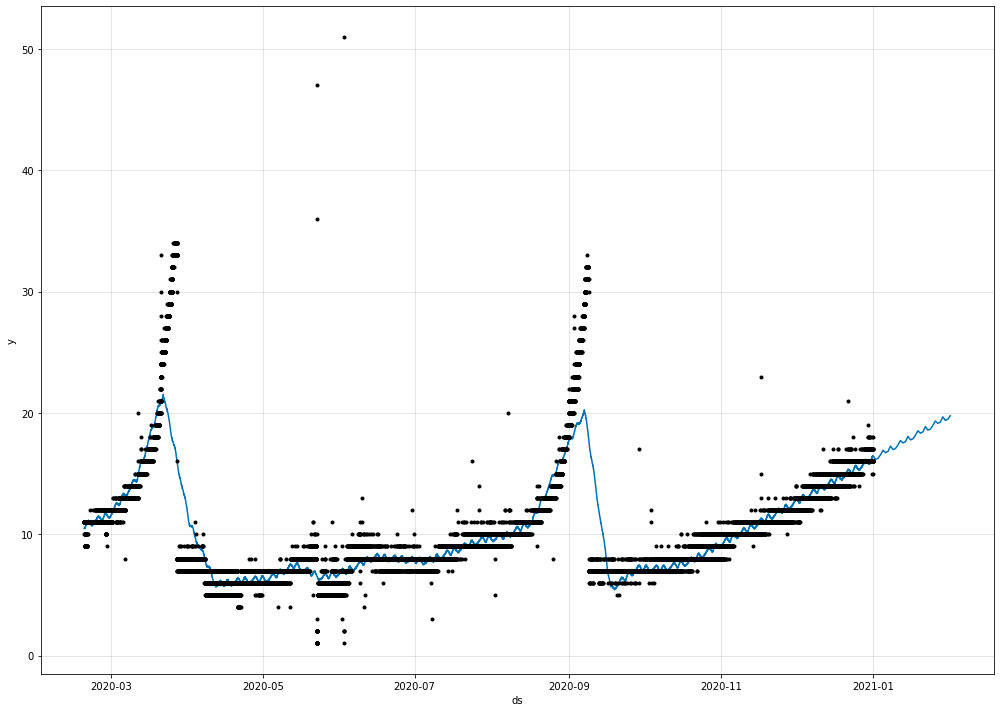

In [9]:
fig, ax = plt.subplots(figsize=(14, 10))
model.plot(forecast, ax=ax)
plt.show()

In [10]:
# model = NeuralProphet() if you're using default variables below.
model = NeuralProphet(**prophet_params)
metrics = model.fit(df, freq="1D")
future = model.make_future_dataframe(df, periods=len(valid), n_historic_predictions=True)
forecast = model.predict(future)

Epoch[50/50]: 100%|██████████| 50/50 [00:53<00:00,  1.07s/it, MSELoss=0.0117, MAE=1.26, RegLoss=0]


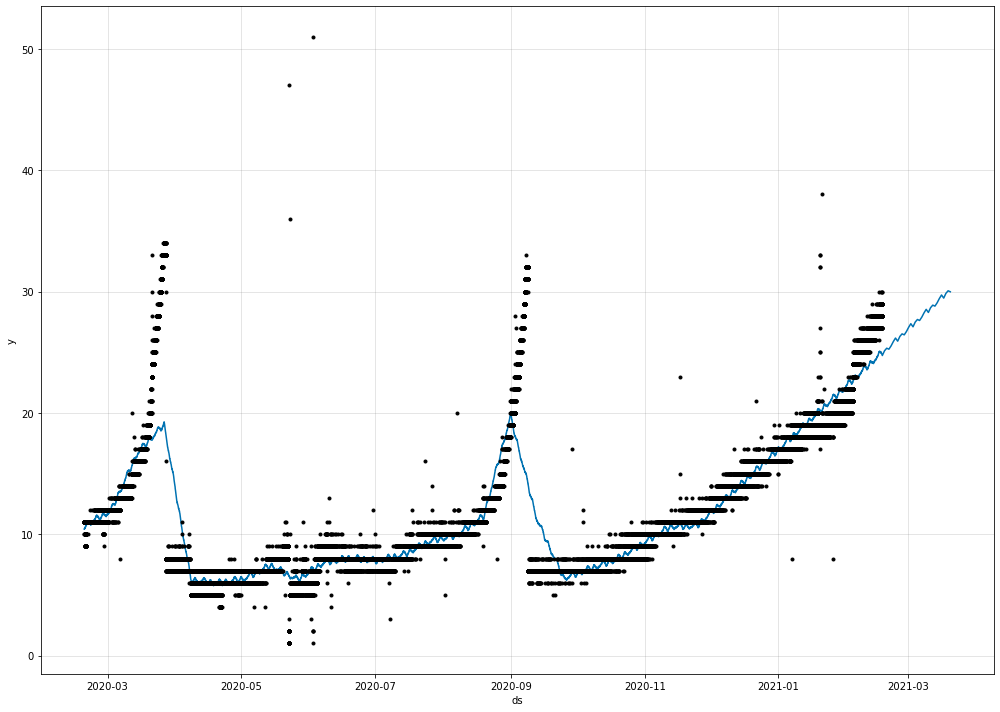

In [11]:
fig, ax = plt.subplots(figsize=(14, 10))
model.plot(forecast, ax=ax)
plt.show()